# HiddenLayer Training Demo - PyTorch

In [1]:
import time
import random
import numpy as np
import torch
import torchvision.models
import torch.nn as nn
from torchvision import datasets, transforms
import hiddenlayer as hl

# Basic Use Case

To track your training, you need to use two Classes: History to store the metrics, and Canvas to draw them.
This example simulates a training loop.

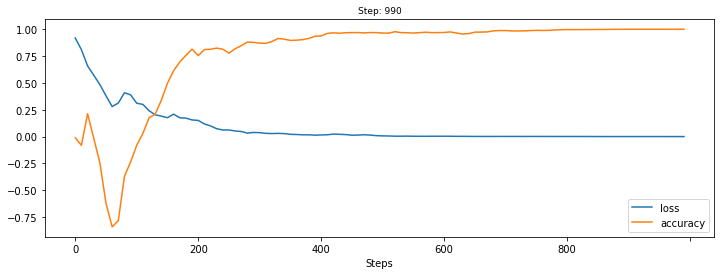

In [2]:
# A History object to store metrics
h = hl.History()

# A Canvas object to draw the metrics
c = hl.Canvas()

# Simulate a training loop with two metrics: loss and accuracy
loss = 1
accuracy = 0
for step in range(1000):
    # Fake loss and accuracy
    loss -= loss * np.random.uniform(-.09, 0.1)
    accuracy += (1 - accuracy) * np.random.uniform(-.09, 0.1)

    # Log metrics and display them at certain intervals
    if step % 10 == 0:
        # Store metrics in the history object
        h.log(step, loss=loss, accuracy=accuracy)

        # Plot the two metrics in one graph
        c.draw_plot(h["loss"], h["accuracy"])

        time.sleep(0.1)

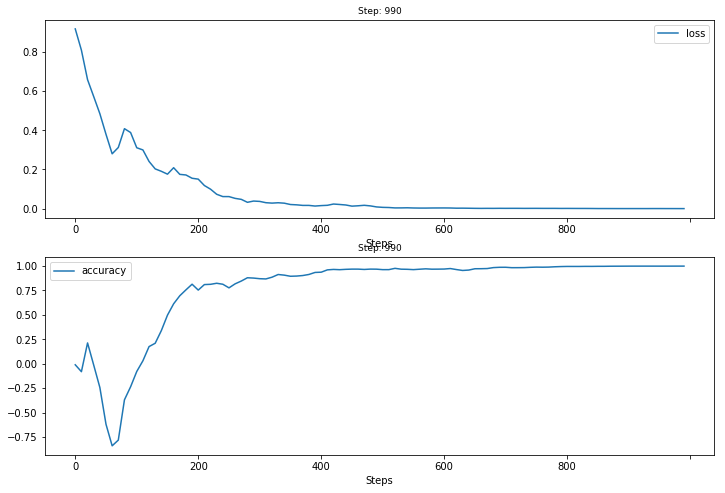

In [3]:
# Or we can plot them in two separate graphs (in one figure) by 
# calling draw_plot() twice inside a "with" context
with c:
    c.draw_plot(h["loss"])
    c.draw_plot(h["accuracy"])

## Running without a GUI

If the training loop is running on a server without a GUI, then track it by printing the progress status and periodically saving a snapshot of the graphs. See `demos/history_demo.py` for an example.

First, set matplotlib backend to Agg.
```Python
# Set matplotlib backend to Agg. MUST be done BEFORE importing hiddenlayer
import matplotlib
matplotlib.use("Agg")
```

Then, in the training loop:
```
    # Print progress status
    h.progress()

    # Occasionally, save a snapshot of the graphs
    c.draw_plot(h["loss"], h["accuracy"])
    c.save("pytorch_demo.png".format(step))
    
```

In [4]:
# The progress() method prints the metrics of the last step.
h.progress()

Step 990: loss: 0.00018474937380054738  accuracy: 0.9995175682655427  


In [5]:
# The History object store the metrics in RAM, which is often good enough for simple 
# expriments. To keep the history, you can save/load them with.
# h.save("basic.pkl")

# And load them with
# h.load("basic.pkl")

# More Metric Types

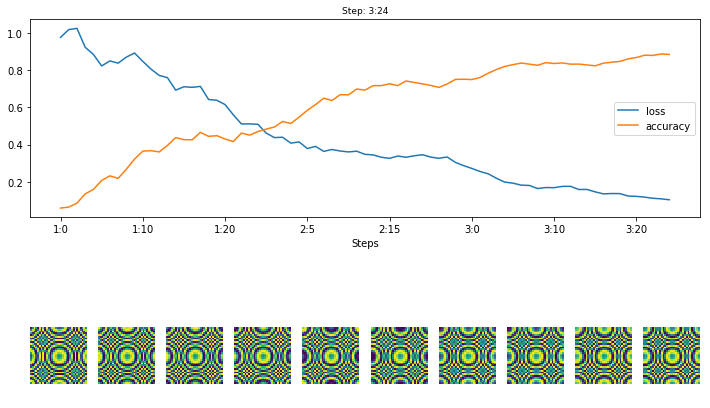

In [6]:
# History and Canvas
h = hl.History()
c = hl.Canvas()

# Simulate a training loop with TODO two metrics: loss and accuracy
loss = 1
accuracy = 0
image = np.zeros([10, 32, 32, 3])
for epoch in range(1, 4):
    for batch_ix in range(25):
        # Fake metrics
        loss -= loss * np.random.uniform(-.05, 0.1)
        accuracy += (1 - accuracy) * np.random.uniform(-.05, 0.1)
        
        # Fake image metric
        # Useful to track images generated by a GAN for example
        image = np.sin(np.sum(((np.indices([32, 32]) - 16) * 0.5 * accuracy) ** 2, 0))

        # Store metrics in the history object
        # TODO: consider a cleaner way to represent epochs
        step = "{}:{}".format(epoch, batch_ix)
        h.log(step, loss=loss, accuracy=accuracy)

        # Store an image metric
        # You can log multiple metrics in one call (as above), or
        # in separate calls so it can be done from where it's convenient
        # in your code.
        h.log(step, image=image[np.newaxis, ...])

        # Plot the two metrics in one graph, and the images reel
        # in a separate under it.
        with c:
            c.draw_plot(h["loss"], h["accuracy"])
            c.draw_images(h["image"])

        time.sleep(0.1)

## Model Training Example

In [7]:
# CIFAR10 Dataset
t = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10('datasets', train=True, download=True, transform=t)
test_dataset = datasets.CIFAR10('datasets', train=False, download=True, transform=t)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Print dataset stats
hl.write("train_dataset.data", train_dataset.train_data)
hl.write("train_dataset.labels", train_dataset.train_labels)
hl.write("test_dataset.data", test_dataset.test_data)
hl.write("test_dataset.labels", test_dataset.test_labels)

train_dataset.data	Tensor  uint8 (50000, 32, 32, 3)  min: 0.000  max: 255.000
train_dataset.labels	list    len: 50000  [6, 9, 9, 4, 1, 1, 2, 7, 8, 3]
test_dataset.data	Tensor  uint8 (10000, 32, 32, 3)  min: 0.000  max: 255.000
test_dataset.labels	list    len: 10000  [3, 8, 8, 0, 6, 6, 1, 6, 3, 1]


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device = ", device)

device =  cpu


In [10]:
# Simple Convolutional Network
class CifarModel(nn.Module):
    def __init__(self):
        super(CifarModel, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.AdaptiveMaxPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32, 32),
#             TODO: nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Linear(32, 10))

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = CifarModel().to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

/home/waleed/miniconda3/envs/dl/lib/python3.6/site-packages/torch/onnx/utils.py:446: UserWarning: ONNX export failed on ATen operator adaptive_max_pool2d because torch.onnx.symbolic.adaptive_max_pool2d does not exist
  .format(op_name, op_name))


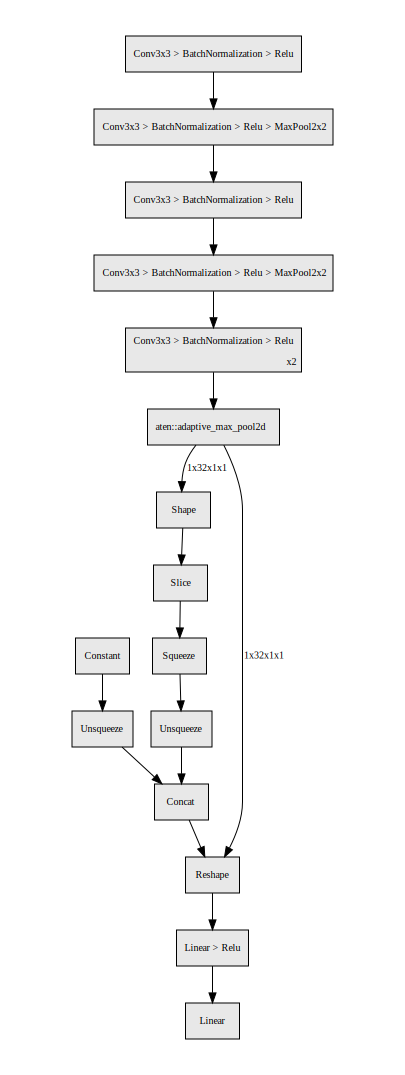

In [11]:
hl.Graph(model, torch.zeros([1, 3, 32, 32]).to(device))

In [12]:
def activations_hook(self, inputs, output):
    """Intercepts the forward pass and logs activations.
    """
    if step and step % 100 == 0:
        h.log(step, conv1_output=output.data[0])
    
# A hook to extract the activations of intermediate layers
model.features[0].register_forward_hook(activations_hook);

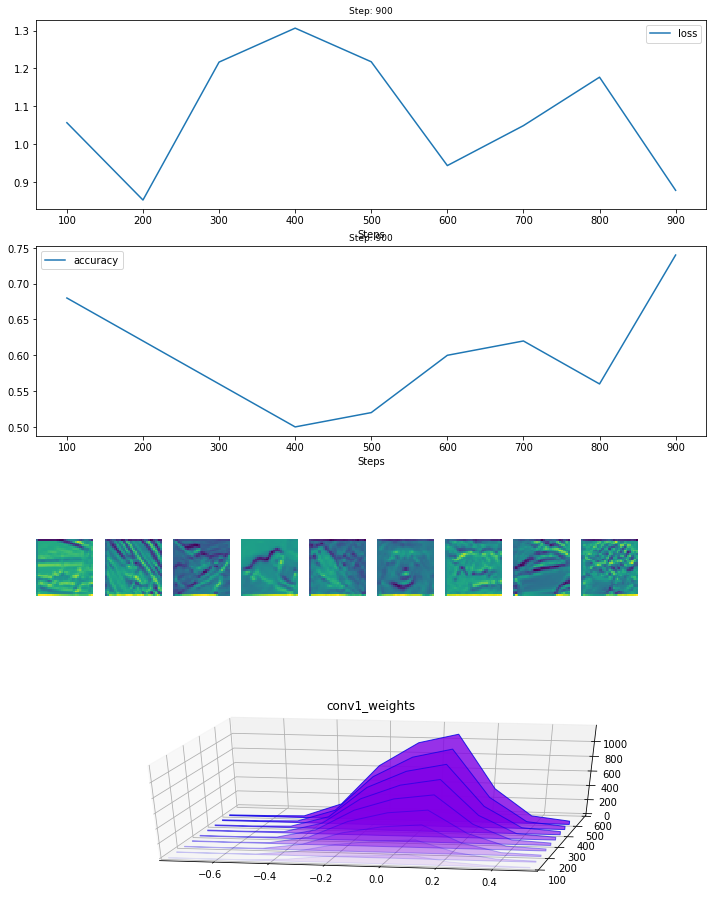

In [14]:
step = 0
h = hl.History()
c = hl.Canvas()

# Training loop
for epoch in range(2):
    step= 0
    train_iter = iter(train_loader)
    for inputs, labels in train_iter:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if step and step % 100 == 0:
            # Compute accuracy
            pred_labels = np.argmax(outputs.detach().cpu().numpy(), 1)
            accuracy = np.mean(pred_labels == labels.detach().cpu().numpy())
            
            h.log(step, epoch=epoch,
                  loss=loss, accuracy=accuracy,
                  conv1_weights=model.features[0].weight,
                  conv2_weights=model.features[3].weight)
            with c:
                c.draw_plot(h["loss"])
                c.draw_plot(h["accuracy"])
                c.draw_images(h["conv1_output"])
                c.draw_hist(h["conv1_weights"])
        step += 1
